In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

# --- GPU setup ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU 0 for training")
    except RuntimeError as e:
        print(e)

# --- Path ---
dataset_path = "/fungel/Rishi_Ridhee_drosophila_stage"  # 8 classes

# --- Parameters ---
batch_size = 64
img_size = (224, 224)
initial_epochs = 10
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.15,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(validation_split=0.15)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_gen = valid_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_labels = list(train_gen.class_indices.keys())
print("Classes:", class_labels)

# --- Base Model ---
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(*img_size, 3))

# Freeze most layers
for layer in base_model.layers:
    layer.trainable = False

# --- Custom Head ---
inputs = keras.Input(shape=(*img_size, 3))
x = layers.Lambda(keras.applications.resnet50.preprocess_input)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Callbacks ---
checkpoint_cb = callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# --- Phase 1: Train Top Layers ---
history1 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=initial_epochs,
    callbacks=[checkpoint_cb, reduce_lr_cb, earlystop_cb]
)

# --- Phase 2: Fine-tune deeper layers ---
for layer in base_model.layers[-40:]:  # Unfreeze last 40 layers
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=5e-5),  # Lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_gen,
    validation_data=valid_gen,
    initial_epoch=history1.epoch[-1],
    epochs=total_epochs,
    callbacks=[checkpoint_cb, reduce_lr_cb, earlystop_cb]
)

# --- Save final model ---
model.save("/fungel/drosophila_stage_resnet50_finetuned.keras")

# ============================
# Plot curves, confusion matrix (same as before)
# ============================


Using GPU 0 for training
Found 6120 images belonging to 8 classes.
Found 1080 images belonging to 8 classes.
Classes: ['1.Egg_augmentated_images', '2.First_Instar_augmentated_images', '3.Second_Instar_augmentated_images', '4.Third_Instar_augmentated_images', '5.White_Pupa_augmentated_images', '6.Brown_Pupa_augmentated_images', '7.Eye_Pupa_augmentated_images', '8.Black_Pupa_augmentated_images']


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,859,720 (91.02 MB)

 Trainable params: 267,656 (1.02 MB)

 Non-trainable params: 23,592,064 (90.00 MB)

Epoch 1/10


I0000 00:00:1753246039.831508    8198 service.cc:146] XLA service 0x7fd5e4815090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753246039.831563    8198 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-07-23 10:17:19.997662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-23 10:17:21.317484: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


 2/96 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.0820 - loss: 3.7458  

I0000 00:00:1753246045.949756    8198 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1767 - loss: 2.9741
Epoch 1: val_accuracy improved from -inf to 0.39444, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 505s 5s/step - accuracy: 0.1774 - loss: 2.9700 - val_accuracy: 0.3944 - val_loss: 1.5432 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4171 - loss: 1.8331
Epoch 2: val_accuracy improved from 0.39444 to 0.48519, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 469s 5s/step - accuracy: 0.4172 - loss: 1.8322 - val_accuracy: 0.4852 - val_loss: 1.2695 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5108 - loss: 1.4423
Epoch 3: val_accuracy improved from 0.48519 to 0.56852, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 472s 5s/step - accuracy: 0.5110 - loss: 1.4418 - val_accuracy: 0.5685 - val_loss: 1.0877 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5889 - loss: 1.1964
Epoch 4: val_accuracy improved from 0.56852 to 0.61481, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 472s 5s/step - accuracy: 0.5889 - loss: 1.1963 - val_accuracy: 0.6148 - val_loss: 0.9794 - learning_rate: 1.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6189 - loss: 1.1213
Epoch 5: val_accuracy improved from 0.61481 to 0.63148, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - accuracy: 0.6190 - loss: 1.1207 - val_accuracy: 0.6315 - val_loss: 0.9320 - learning_rate: 1.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6385 - loss: 1.0128
Epoch 6: val_accuracy improved from 0.63148 to 0.63426, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.6386 - loss: 1.0124 - val_accuracy: 0.6343 - val_loss: 0.8910 - learning_rate: 1.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6750 - loss: 0.9159
Epoch 7: val_accuracy improved from 0.63426 to 0.64074, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 480s 5s/step - accuracy: 0.6751 - loss: 0.9158 - val_accuracy: 0.6407 - val_loss: 0.8633 - learning_rate: 1.0000e-04
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7021 - loss: 0.8500
Epoch 8: val_accuracy improved from 0.64074 to 0.65926, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 466s 5s/step - accuracy: 0.7021 - loss: 0.8499 - val_accuracy: 0.6593 - val_loss: 0.8331 - learning_rate: 1.0000e-04
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7062 - loss: 0.8077
Epoch 9: val_accuracy improved from 0.65926 to 0.66204, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.7062 - loss: 0.8076 - val_accuracy: 0.6620 - val_loss: 0.8220 - learning_rate: 1.0000e-04
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7252 - loss: 0.7839
Epoch 10: val_accuracy improved from 0.66204 to 0.67037, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 463s 5s/step - accuracy: 0.7253 - loss: 0.7836 - val_accuracy: 0.6704 - val_loss: 0.8074 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.
Epoch 10/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7610 - loss: 0.6750
Epoch 10: val_accuracy improved from 0.67037 to 0.74722, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.7614 - loss: 0.6737 - val_accuracy: 0.7472 - val_loss: 0.6679 - learning_rate: 5.0000e-05
Epoch 11/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9030 - loss: 0.2983
Epoch 11: val_accuracy improved from 0.74722 to 0.80000, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.9031 - loss: 0.2980 - val_accuracy: 0.8000 - val_loss: 0.5265 - learning_rate: 5.0000e-05
Epoch 12/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9498 - loss: 0.1733
Epoch 12: val_accuracy improved from 0.80000 to 0.82778, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 0.9498 - loss: 0.1732 - val_accuracy: 0.8278 - val_loss: 0.4812 - learning_rate: 5.0000e-05
Epoch 13/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9642 - loss: 0.1385
Epoch 13: val_accuracy improved from 0.82778 to 0.84352, saving model to best_model.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 469s 5s/step - accuracy: 0.9642 - loss: 0.1385 - val_accuracy: 0.8435 - val_loss: 0.5319 - learning_rate: 5.0000e-05
Epoch 14/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9762 - loss: 0.1148
Epoch 14: val_accuracy did not improve from 0.84352
96/96 ━━━━━━━━━━━━━━━━━━━━ 480s 5s/step - accuracy: 0.9762 - loss: 0.1147 - val_accuracy: 0.8296 - val_loss: 0.5509 - learning_rate: 5.0000e-05
Epoch 15/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9805 - loss: 0.0899
Epoch 15: val_accuracy did not improve from 0.84352

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
96/96 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.9805 - loss: 0.0900 - val_accuracy: 0.8222 - val_loss: 0.6189 - learning_rate: 5.0000e-05
Epoch 16/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9823 - loss: 0.0817
Epoch 16: val_accuracy did not improve from 0.84352
96/96 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.9824 - loss: 0.0817 - val_ac

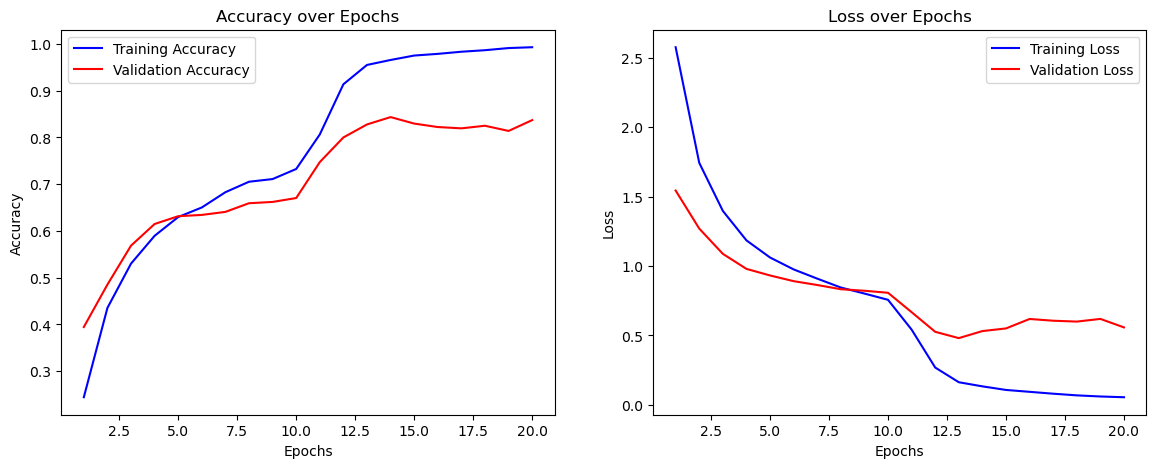

 2/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras

# --- Load the best model (fix for Lambda layer issue) ---
best_model = keras.models.load_model('best_model.h5', custom_objects={'preprocess_input': preprocess_input})

# --- Plot Training & Validation Curves ---
def plot_training_curves(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Call the function
plot_training_curves(history1, history2)

# --- Predict on Validation Set ---
valid_gen.reset()
y_pred_probs = best_model.predict(valid_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = valid_gen.classes

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
class_labels = list(valid_gen.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Classification Report ---
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("\nClassification Report:\n", report)
